In [2]:
#Importing Libraries
import pandas as pd
import os
import numpy as np
import pandas as pd # to import csv and for data manipulation
import matplotlib.pyplot as plt # to plot graph
import seaborn as sns # for intractve graphs
import numpy as np # for linear algebra
import datetime # to dela with date and time
%matplotlib inline
from sklearn.preprocessing import StandardScaler # for preprocessing the data
from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from sklearn.tree import DecisionTreeClassifier # for Decision Tree classifier
from sklearn.svm import SVC # for SVM classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # to split the data
from sklearn.model_selection import KFold # For cross vbalidation
from sklearn.model_selection import GridSearchCV # for tunnig hyper parameter it will use all combination of given parameters
from sklearn.model_selection import RandomizedSearchCV # same for tunning hyper parameter but will use random combinations of parameters
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
import pandas  as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

# Reading Datasets

In [3]:
telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')

#format datetime field which comes in as string in telemetry
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
#Print total number of records in telemetry
#print('Total number of telemetry records: {}'.format(len(telemetry.index)))

# format datetime field which comes in as string in Errors
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')
#Print total number of records in Errors
#print('Total number of error records: {}'.format(len(errors.index)))

# format datetime field which comes in as string in Maint
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')
#print('Total number of maintenance records: {}'.format(len(maint.index)))

#Machine details
machines['model'] = machines['model'].astype('category')
#print('Total number of machines: {}'.format(len(machines.index)))

# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')
#print('Total number of failures: {}'.format(len(failures.index)))

# Feature Engineering

In [4]:
#Define interval
Hours='24H'

In [5]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample(Hours, closed='left', label='right').mean().unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)

# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample(Hours, closed='left', label='right').std().unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h.reset_index(inplace=True)

telemetry_mean_24h.head()

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
0,1,2015-01-02,167.576533,440.515328,98.522345,40.049623
1,1,2015-01-03,169.795758,446.832666,98.454608,39.271645
2,1,2015-01-04,171.862244,459.204742,97.998233,48.074091
3,1,2015-01-05,174.792428,448.743201,101.452266,52.190268
4,1,2015-01-06,171.018408,454.822750,102.363114,43.330311


In [6]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_24h,
                            telemetry_sd_24h.ix[:, 2:6]], axis=1).dropna()
#telemetry_feat.describe()

In [7]:
# create a column for each error type
error_count = pd.get_dummies(errors)
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']

# combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
#error_count.head()

#Merge 2 datasets, telemetry and errors
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
#error_count.describe()

In [8]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                               index='datetime',
                               columns='machineID',
                               values=col).resample(Hours,closed='left',label='right').sum().unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
#error_count.describe()

In [9]:
#labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
# fill backward up to 24h 
#labeled_features = labeled_features.bfill(axis=1, limit=5)
#labeled_features = labeled_features.fillna('none')
#labeled_features.head()

In [10]:
# create a column for each failure type
failures_count = pd.get_dummies(failures)
failures_count.columns = ['datetime', 'machineID', 'Fail-comp1', 'Fail-comp2', 'Fail-comp3', 'Fail-comp4']

# combine faiures for a given machine in a given hour
failures_count = failures_count.groupby(['machineID', 'datetime']).sum().reset_index()
failures_count = telemetry[['datetime', 'machineID']].merge(failures_count, on=['machineID', 'datetime'], how='left').fillna(0.0)

In [11]:
temp = []
fields = ['Fail-comp1', 'Fail-comp2', 'Fail-comp3', 'Fail-comp4']
for col in fields:
    temp.append(pd.pivot_table(failures_count,
                               index='datetime',
                               columns='machineID',
                               values=col).resample(Hours,closed='left',
                               label='right').sum().unstack())
failures_count = pd.concat(temp, axis=1)
failures_count.columns = ['Fail-comp1', 'Fail-comp2', 'Fail-comp3', 'Fail-comp4']
failures_count.reset_index(inplace=True)
failures_count = failures_count.dropna()
#failures_count.describe()

In [12]:
import numpy as np
# create a column for each error type
comp_rep = pd.get_dummies(maint)
comp_rep.columns = ['datetime', 'machineID','comp1_rep', 'comp2_rep', 'comp3_rep', 'comp4_rep']

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1_rep', 'comp2_rep', 'comp3_rep', 'comp4_rep']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')
    
# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

for comp in components:
    comp_rep[comp] = pd.to_datetime(comp_rep[comp], format="%Y-%m-%d %H:%M:%S")
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]).apply(lambda x: x / pd.Timedelta(days=1))
#comp_rep.describe()

In [13]:
#Merging the dataset
final_feat = telemetry_feat.merge(machines, on=['machineID'], how='left')
final_feat =final_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(failures_count, on=['datetime', 'machineID'], how='left')

# 100 Seperated DataFrames

In [14]:
#Splitting dataset per machineID
final_featM = {}
for MID in range(1,101):
    final_featM[MID] = pd.DataFrame(final_feat.loc[final_feat["machineID"]==MID])
    
#for MID in range(1,101):
     #print(final_featM[MID].head())

In [15]:
#New coloums created
for MID in range(1,101):
    final_featM[MID]['Errors'] = final_featM[MID]["error1count"]+ final_featM[MID]["error4count"] +final_featM[MID]["error2count"]+ final_featM[MID]["error3count"]+ final_featM[MID]["error5count"]
    final_featM[MID]['Sum of Comp-Fail']=final_featM[MID]['Fail-comp1']+final_featM[MID]['Fail-comp2'] + final_featM[MID]['Fail-comp3'] +final_featM[MID]['Fail-comp4']

In [16]:
for MID in range(1,101):
    #Count time until to failure coloumn
    x=-1
    Count = []
    count = [] 
    DifferenceBetweenFailures = {}
    for Mcomp1 in  final_featM[MID]['Sum of Comp-Fail']: 
            if ((Mcomp1 == 0)): 
                count.append(x+1) 
                x=x+1
            elif ((Mcomp1 >= 1)): 
                count.append(x+1)
                Count.append (x)
                x=-1   
    Count.append (x)
    final_featM[MID]["CountLifetotal"] = count
    DifferenceBetweenFailures[MID] = pd.DataFrame(Count)
 #Flip to calculate RUL
    RULComp1 = [] 
    x=-1
    R=0
    Y=0
    Y2=0
    for T in  final_featM[MID]["CountLifetotal"]: 
           if (x<(len(DifferenceBetweenFailures[MID])-1)):
                if (T > 0): 
                    RULComp1.append((DifferenceBetweenFailures[MID].loc[x,0])-R) 
                    R=R+1
                elif ((T == 0)): 
                    x=x+1
                    RULComp1.append((DifferenceBetweenFailures[MID].loc[x,0]))
                    R=0
           elif (x == len(DifferenceBetweenFailures[MID])):
                RULComp1.append((DifferenceBetweenFailures[MID].loc[x,0])-Y)
                Y=Y+1
                x=len(dfComp1)
           else:
                x=len(DifferenceBetweenFailures[MID])-1
                RULComp1.append((DifferenceBetweenFailures[MID].loc[x,0])-Y2)
                Y2=Y2+1

    final_featM[MID]['Sum of Comp-RUL'] = RULComp1


In [17]:
#for MID in range(1,101):
     #print(final_featM[MID].head())

#Saving as CSV files
#for MID in range(1,101):
     #final_featM[MID].to_csv('24hrAv{}.csv'.format(MID))

In [18]:
final_featLR={}
for MID in range(1,101):
     final_featM[MID]['Failure']=final_featM[MID]['Sum of Comp-Fail']
     final_featLR[MID]=final_featM[MID].drop(['Fail-comp1','Fail-comp2','Fail-comp3',
                                       'Fail-comp4','machineID','Sum of Comp-RUL',
                                              'Sum of Comp-Fail','error1count','error2count',
                                              'error3count','error4count','error5count'],axis=1)

In [19]:
temp=[]
for MID in range(1,50):
    temp.append(final_featLR[MID])
data=pd.concat(temp)

In [20]:
data['Failure'].head(5)

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: Failure, dtype: float64

In [21]:
data['Failure'].value_counts()

0.0    17590
1.0      319
2.0       25
Name: Failure, dtype: int64

In [22]:
    #0 or 1
    ColoumSum=[]
    for T in data['Failure']:
        if ((T == 0)): 
            ColoumSum.append(0) 
        elif ((T >= 1)): 
            ColoumSum.append(1)

    data['Failure'] = ColoumSum

    

In [23]:
data['Failure'].value_counts()

0    17590
1      344
Name: Failure, dtype: int64

In [24]:
count_no_sub = len(data[data['Failure']==0])
count_sub = len(data[data['Failure']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no failures is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of failures", pct_of_sub*100)

percentage of no failures is 98.08185569309691
percentage of failures 1.9181443069030892


In [25]:
#Count time until to failure coloumn
x=1
ColoumSum=[]
for Mcomp1 in  data['Failure']: 
        if ((Mcomp1 == 0)): 
            ColoumSum.append(x) 
        elif ((Mcomp1 >= 1)): 
            ColoumSum.append(x+1)
            x=x+1

data["ColoumSum"] = ColoumSum
#print(data["ColoumSum"]) 
feat1=[]
for T in range(1,x+1):
    df=data.loc[data["ColoumSum"]== T]
    #AVG
    df['AvVolt2'] = df.iloc[:,2].rolling(window=4,min_periods = 0).mean().fillna(df['voltmean_24h'])
    df['AvRotate2'] =df.iloc[:,3].rolling(window=4,min_periods = 0).mean().fillna(df['rotatemean_24h'])
    df['AvPressure2'] = df.iloc[:,4].rolling(window=4,min_periods = 0).mean().fillna(df['pressuremean_24h'])
    df['AvVibration2'] = df.iloc[:,5].rolling(window=4,min_periods = 0).mean().fillna(df['vibrationmean_24h'])
    #STD
    df['STDVolt2'] = df.iloc[:,2].rolling(window=4,min_periods = 0).std().fillna(df['voltsd_24h'])
    df['STDRotate2'] = df.iloc[:,3].rolling(window=4,min_periods = 0).std().fillna(df['rotatesd_24h'])
    df['STDPressure2'] = df.iloc[:,4].rolling(window=4,min_periods = 0).std().fillna(df['pressuresd_24h'])
    df['STDVibration2'] = df.iloc[:,5].rolling(window=4,min_periods = 0).std().fillna(df['vibrationsd_24h'])

    feat1.append(df)
    final_feat1=pd.concat(feat1)

In [26]:
data= final_feat1

In [27]:
data=data.drop(['ColoumSum'],axis=1)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17934 entries, 0 to 17933
Data columns (total 26 columns):
datetime             17934 non-null datetime64[ns]
voltmean_24h         17934 non-null float64
rotatemean_24h       17934 non-null float64
pressuremean_24h     17934 non-null float64
vibrationmean_24h    17934 non-null float64
voltsd_24h           17934 non-null float64
rotatesd_24h         17934 non-null float64
pressuresd_24h       17934 non-null float64
vibrationsd_24h      17934 non-null float64
model                17934 non-null category
age                  17934 non-null int64
comp1_rep            17885 non-null float64
comp2_rep            17885 non-null float64
comp3_rep            17885 non-null float64
comp4_rep            17885 non-null float64
Errors               17934 non-null float64
CountLifetotal       17934 non-null int64
Failure              17934 non-null int64
AvVolt2              17934 non-null float64
AvRotate2            17934 non-null float64
AvPressur

In [29]:
data=data.ffill(axis=0)

In [30]:
#Changing to dummy coloumns
cat_vars=['model']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
cat_vars=['model']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [31]:
data=data[to_keep]
data.columns.values

array(['datetime', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'age', 'comp1_rep',
       'comp2_rep', 'comp3_rep', 'comp4_rep', 'Errors', 'CountLifetotal',
       'Failure', 'AvVolt2', 'AvRotate2', 'AvPressure2', 'AvVibration2',
       'STDVolt2', 'STDRotate2', 'STDPressure2', 'STDVibration2',
       'model_model1', 'model_model2', 'model_model3', 'model_model4'],
      dtype=object)

In [32]:
print(data['Failure'].head())
data2=data

0    0
1    0
2    0
3    0
4    1
Name: Failure, dtype: int64


# Shift Starts Here

In [40]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in, n_out, dropnan=True):
    
#Frame a time series as a supervised learning dataset.
#Arguments:
#data: Sequence of observations as a list or NumPy array.
#n_in: Number of lag observations as input (X).
#n_out: Number of observations as output (y).
#dropnan: Boolean whether or not to drop rows with NaN values.
#Returns:
#Pandas DataFrame of series framed for supervised learning.

    #n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if i == 0:
            names += [('Failure')]
        elif i == 1:
            names += [('Failure+1')]
        elif i == 2:
            names += [('Failure+2')]
        #elif i == 3:
         #   names += [('Failure+3')]
        #elif i == 4:
         #   names += [('Failure+4')]
        #elif i == 5:
         #   names += [('Failure+5')]
        #elif i == 6:
         #   names += [('Failure+6')]
        #elif i == 7:
         #   names += [('Failure+7')]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Failure')]
        elif i == 1:
            names += [('Failure-1')]
        elif i == 2:
            names += [('Failure-2')]
        elif i == 3:
            names += [('Failure-3')]
        elif i == 4:
            names += [('Failure-4')]
        elif i == 5:
            names += [('Failure-5')]
        elif i == 6:
            names += [('Failure-6')]
        elif i == 7:
            names += [('Failure-7')]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
values = data2['Failure']
data = series_to_supervised(values, 2,8)
data=data.fillna(0)
print(data)

       Failure+2  Failure+1  Failure  Failure-1  Failure-2  Failure-3  \
2            0.0        0.0        0        0.0        1.0        0.0   
3            0.0        0.0        0        1.0        0.0        0.0   
4            0.0        0.0        1        0.0        0.0        0.0   
5            0.0        1.0        0        0.0        0.0        0.0   
6            1.0        0.0        0        0.0        0.0        0.0   
...          ...        ...      ...        ...        ...        ...   
17922        0.0        0.0        0        0.0        0.0        0.0   
17923        0.0        0.0        0        0.0        0.0        0.0   
17924        0.0        0.0        0        0.0        0.0        1.0   
17925        0.0        0.0        0        0.0        1.0        0.0   
17926        0.0        0.0        0        1.0        0.0        0.0   

       Failure-4  Failure-5  Failure-6  Failure-7  
2            0.0        0.0        0.0        0.0  
3            0.0   

In [41]:
data2['Failure-1']=data['Failure-1']
data2['Failure-2']=data['Failure-2']
data2['Failure-3']=data['Failure-3']
data2['Failure-4']=data['Failure-4']
data2['Failure-5']=data['Failure-5']
data2['Failure-6']=data['Failure-6']
data2['Failure-7']=data['Failure-7']

data2['Failure+1']=data['Failure+1']
data2['Failure+2']=data['Failure+2']
#data2['Failure+3']=data['Failure+3']
#data2['Failure+4']=data['Failure+4']
#data2['Failure+5']=data['Failure+5']
#data2['Failure+6']=data['Failure+6']
#data2['Failure+7']=data['Failure+7']

In [42]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in, n_out, dropnan=False):
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        #names += [('Errors+1')]
        if i == 0:
            names += [('Errors')]
        elif i == 1:
            names += [('Errors+1')]
        elif i == 2:
            names += [('Errors+2')]
        elif i == 3:
            names += [('Errors+3')] 
        elif i == 4:
            names += [('Errors+4')]
        elif i == 5:
            names += [('Errors+5')]
        elif i == 6:
            names += [('Errors+6')]
        elif i == 7:
            names += [('Errors+7')]
    # forecast sequence (t, t+1, ... t+n)
    #for i in range(0, n_out):
        #cols.append(df.shift(-i))
        #if i == 0:
         #   names += [('Errors')]
        #elif i == 1:
         #   names += [('Errors-1')]
        #elif i == 2:
         #   names += [('Errors-2')]
        #elif i == 3:
         #   names += [('Errors-3')] 
        #elif i == 4:
         #   names += [('Errors-4')]
        #elif i == 5:
         #   names += [('Errors-5')]
        #elif i == 6:
         #   names += [('Errors-6')]
        #elif i == 7:
         #   names += [('Errors-7')]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
values = data2['Errors']
data = series_to_supervised(values, 7, 1)
data=data.fillna(0)
print(data)

       Errors+7  Errors+6  Errors+5  Errors+4  Errors+3  Errors+2  Errors+1
0           0.0       0.0       0.0       0.0       0.0       0.0       0.0
1           0.0       0.0       0.0       0.0       0.0       0.0       0.0
2           0.0       0.0       0.0       0.0       0.0       0.0       0.0
3           0.0       0.0       0.0       0.0       0.0       0.0       2.0
4           0.0       0.0       0.0       0.0       0.0       2.0       1.0
...         ...       ...       ...       ...       ...       ...       ...
17929       0.0       0.0       0.0       0.0       1.0       0.0       0.0
17930       0.0       0.0       0.0       1.0       0.0       0.0       0.0
17931       0.0       0.0       1.0       0.0       0.0       0.0       0.0
17932       0.0       1.0       0.0       0.0       0.0       0.0       0.0
17933       1.0       0.0       0.0       0.0       0.0       0.0       0.0

[17934 rows x 7 columns]


In [43]:
data2['Errors+1']=data['Errors+1']
data2['Errors+2']=data['Errors+2']
data2['Errors+3']=data['Errors+3']
data2['Errors+4']=data['Errors+4']
data2['Errors+5']=data['Errors+5']
data2['Errors+6']=data['Errors+6']
data2['Errors+7']=data['Errors+7']

In [44]:
data2=data2.fillna(0)

In [45]:
#Sh=-1
#Delete Failure coloumns to shift failure up
#data2['Failure']=data2['Failure'].shift(Sh).fillna(0)

In [46]:
data2['Failure'].head()

0    0
1    0
2    0
3    0
4    1
Name: Failure, dtype: int64

In [64]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17934 entries, 0 to 17933
Data columns (total 45 columns):
datetime             17934 non-null datetime64[ns]
voltmean_24h         17934 non-null float64
rotatemean_24h       17934 non-null float64
pressuremean_24h     17934 non-null float64
vibrationmean_24h    17934 non-null float64
voltsd_24h           17934 non-null float64
rotatesd_24h         17934 non-null float64
pressuresd_24h       17934 non-null float64
vibrationsd_24h      17934 non-null float64
age                  17934 non-null int64
comp1_rep            17934 non-null float64
comp2_rep            17934 non-null float64
comp3_rep            17934 non-null float64
comp4_rep            17934 non-null float64
Errors               17934 non-null float64
CountLifetotal       17934 non-null int64
Failure              17934 non-null int64
AvVolt2              17934 non-null float64
AvRotate2            17934 non-null float64
AvPressure2          17934 non-null float64
AvVibratio

In [212]:
data2.to_csv('checkna.csv')

# Model

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
AccScore=[]
# make test and training splits
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]


for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    y_train = data2.loc[data2['datetime'] <pd.to_datetime('2015-08-30 01:00:00'), 'Failure-1']
    X_train= pd.get_dummies(data2.loc[data2['datetime'] < pd.to_datetime('2015-08-30 01:00:00')].drop(['datetime',      
                                                                                                        'Failure','Failure-1','Failure-2','Failure-3','Failure-4','Failure-5','Failure-6','Failure-7',
                                                                                                      'Errors+1','Errors+2','Errors+3','Errors+4','Errors+5','Errors+6','Errors+7'], 1))
    X_test = pd.get_dummies(data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00')].drop(['datetime',
                                                                                                       'Failure','Failure-1','Failure-2','Failure-3','Failure-4','Failure-5','Failure-6','Failure-7',
                                                                                                       'Errors+1','Errors+2','Errors+3','Errors+4','Errors+5','Errors+6','Errors+7'] ,1))
    y_test = data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00'), 'Failure-1']
    
    # Feature Scaling
    #scaler = StandardScaler()
    #train_X = scaler.fit_transform(train_X)
    #test_X = scaler.transform(test_X)



In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
RecallScore=[]
AccuracyScore=[]
f1Score=[]
for i in range (1,8):
    # make test and training splits
    threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                       [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                       [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]


    for last_train_date, first_test_date in threshold_dates:
        # split out training and test data
        y_train = data2.loc[data2['datetime'] <pd.to_datetime('2015-08-30 01:00:00'), 'Failure-{}'.format(i)]
        X_train= pd.get_dummies(data2.loc[data2['datetime'] < pd.to_datetime('2015-08-30 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1','Failure-2','Failure-3','Failure-4','Failure-5','Failure-6','Failure-7',
                                                                                                          'Errors+1','Errors+2','Errors+3','Errors+4','Errors+5','Errors+6','Errors+7'], 1))
        X_test = pd.get_dummies(data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00')].drop(['datetime',
                                                                                                           'Failure','Failure-1','Failure-2','Failure-3','Failure-4','Failure-5','Failure-6','Failure-7',
                                                                                                           'Errors+1','Errors+2','Errors+3','Errors+4','Errors+5','Errors+6','Errors+7'] ,1))
        y_test = data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00'), 'Failure-{}'.format(i)]

    
    
    #logistic regression object 
    RF = RandomForestClassifier(n_estimators=100) 

    # train the model on train set 
    RF.fit(X_train, y_train.values.ravel()) 

    predictions = RF.predict(X_test) 

    # print classification report 
    #print(classification_report(y_test, predictions))
    #Recall Value
    # Use score method to get accuracy of model

    Ascore = accuracy_score(y_test,predictions)
    AccuracyScore.append(Ascore)
    
    Rscore = recall_score(y_test,predictions)
    RecallScore.append(Rscore)
    
    f1score = f1_score(y_test,predictions)
    f1Score.append(f1score)

print (RecallScore)
print(AccuracyScore)
print(f1Score)

[0.875, 0.27586206896551724, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.9973452795752448, 0.9858967977434876, 0.9809191969470715, 0.9809191969470715, 0.9809191969470715, 0.9809191969470715, 0.9805873568939771]
[0.9245283018867924, 0.42953020134228187, 0.0, 0.0, 0.0, 0.0, 0.0]


In [218]:
X_test.to_csv('tesdata.csv')

In [251]:
from sklearn.model_selection import cross_val_score
X= data2.ix[:,data2.columns != "Failure-1"].drop(['datetime','Failure','Failure-2','Failure-3','Failure-4','Failure-5','Failure-6','Failure-7'],1)
y=data2.ix[:,data2.columns=="Failure-1"]
#print(cross_val_score(lr1, X, y, cv=3))

In [252]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kfold = KFold(n_splits=10)

results = cross_validate (estimator=lr, X=X,y=y,cv=kfold, scoring=scoring)
print(results)

{'fit_time': array([0.38831139, 0.40737128, 0.43855643, 0.40930247, 0.4482522 ,
       0.41630316, 0.43034482, 0.39389014, 0.4042604 , 0.41349006]), 'score_time': array([0.02326298, 0.02251935, 0.02226925, 0.01651716, 0.01765633,
       0.01523972, 0.01541471, 0.02089   , 0.01892495, 0.01657677]), 'test_accuracy': array([0.98216276, 0.98439242, 0.98550725, 0.97658863, 0.96932515,
       0.98717234, 0.98717234, 0.97992192, 0.98047964, 0.97936419]), 'test_precision': array([0.33333333, 0.5       , 0.52941176, 0.6875    , 0.46153846,
       0.4       , 0.91666667, 0.45454545, 0.5       , 0.42857143]), 'test_recall': array([0.18518519, 0.17857143, 0.33333333, 0.22916667, 0.11111111,
       0.19047619, 0.33333333, 0.14285714, 0.08571429, 0.17142857]), 'test_f1_score': array([0.23809524, 0.26315789, 0.40909091, 0.34375   , 0.17910448,
       0.25806452, 0.48888889, 0.2173913 , 0.14634146, 0.24489796])}


# Logistic Regression

In [250]:
y_pred_new_threshold = (lr.predict_proba(X_test)[:,1]>=0.5).astype(int)

print(classification_report(y_test, y_pred_new_threshold))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_pred_new_threshold)
print(confusion_matrix)


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      5915
         1.0       0.44      0.17      0.25       112

    accuracy                           0.98      6027
   macro avg       0.71      0.58      0.62      6027
weighted avg       0.97      0.98      0.98      6027

[[5891   24]
 [  93   19]]


In [71]:
# logistic regression object 
lr = LogisticRegression() 
  
# train the model on train set 
lr.fit(X_train, y_train.values.ravel()) 
  
predictions = lr.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

#from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix)

 #get importance
#importance = lr.coef_[0]
#summarize feature importance
#for i,v in enumerate(importance):
 #   print('Feature: %0d, Score: %.5f' % (i,v))
#plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5915
         1.0       0.49      0.21      0.30       112

    accuracy                           0.98      6027
   macro avg       0.74      0.61      0.64      6027
weighted avg       0.98      0.98      0.98      6027

[[5890   25]
 [  88   24]]


In [69]:
from sklearn.ensemble import RandomForestRegressor

# logistic regression object 
lr = RandomForestRegressor() 
  
# train the model on train set 
lr.fit(X_train, y_train.values.ravel()) 
  
predictions = lr.predict(X_test) 
  


In [70]:
# Evaluating the Algorithm
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions ))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions ))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions )))

Mean Absolute Error: 0.00476854156296665
Mean Squared Error: 0.0023617388418782147
Root Mean Squared Error: 0.04859772465741801


In [72]:
# Evaluating the Algorithm
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions ))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions ))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions )))

Mean Absolute Error: 0.01874896299983408
Mean Squared Error: 0.01874896299983408
Root Mean Squared Error: 0.13692685273471408


In [172]:
#Recall Value
# Use score method to get accuracy of model
score = recall_score(y_test,predictions)
print(score)

0.0


In [170]:
#f1_score
from sklearn.metrics import f1_score
# Use score method to get accuracy of model
score = f1_score(y_test,predictions)
print(score)

0.0


In [171]:
 from sklearn.metrics import accuracy_score
# Use score method to get accuracy of model
score = accuracy_score(y_test,predictions)
print(score)

0.9814169570267132


Feature: 0, Score: 0.16325
Feature: 1, Score: -0.01990
Feature: 2, Score: 0.07455
Feature: 3, Score: 0.16875
Feature: 4, Score: -0.01608
Feature: 5, Score: -0.03465
Feature: 6, Score: -0.02334
Feature: 7, Score: -0.01365
Feature: 8, Score: 0.05100
Feature: 9, Score: 0.02927
Feature: 10, Score: 0.02850
Feature: 11, Score: 0.02981
Feature: 12, Score: 0.01816
Feature: 13, Score: 0.02528
Feature: 14, Score: 0.00109
Feature: 15, Score: 0.00243
Feature: 16, Score: 0.00243
Feature: 17, Score: 0.00511
Feature: 18, Score: 0.00828
Feature: 19, Score: -0.03960
Feature: 20, Score: 0.08464
Feature: 21, Score: 0.14757
Feature: 22, Score: 0.01208
Feature: 23, Score: -0.02886
Feature: 24, Score: -0.08495
Feature: 25, Score: 0.00054
Feature: 26, Score: 0.00647
Feature: 27, Score: -0.06036
Feature: 28, Score: -0.05460
Feature: 29, Score: -0.01877
Feature: 30, Score: -0.01649
Feature: 31, Score: -0.06046
Feature: 32, Score: -0.03749
Feature: 33, Score: 0.01843
Feature: 34, Score: 0.00059
Feature: 35, Sco

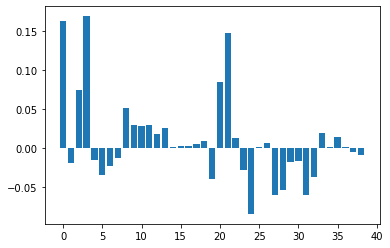

In [50]:

# logistic regression for feature importance
from sklearn.datasets import make_classification

from matplotlib import pyplot
# get importance
importance = lr.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()


In [ ]:
#Oversampling

In [105]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.values.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

lr1 = LogisticRegression() 
lr1.fit(X_train_res, y_train_res.ravel()) 
predictions = lr1.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix)

Before OverSampling, counts of label '1': 231
Before OverSampling, counts of label '0': 11578 

After OverSampling, the shape of train_X: (23156, 39)
After OverSampling, the shape of train_y: (23156,) 

After OverSampling, counts of label '1': 11578
After OverSampling, counts of label '0': 11578
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      5915
         1.0       0.18      0.94      0.30       112

    accuracy                           0.92      6027
   macro avg       0.59      0.93      0.63      6027
weighted avg       0.98      0.92      0.94      6027

[[5431  484]
 [   7  105]]


In [76]:
#UnderSampling

In [106]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# apply near miss 
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.values.ravel()) 
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

# train the model on train set 
lr2 = LogisticRegression() 
lr2.fit(X_train_miss, y_train_miss.ravel()) 
predictions = lr2.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix)

Before Undersampling, counts of label '1': 231
Before Undersampling, counts of label '0': 11578 

After Undersampling, the shape of train_X: (462, 39)
After Undersampling, the shape of train_y: (462,) 

After Undersampling, counts of label '1': 231
After Undersampling, counts of label '0': 231
              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86      5915
         1.0       0.07      0.92      0.13       112

    accuracy                           0.76      6027
   macro avg       0.53      0.84      0.50      6027
weighted avg       0.98      0.76      0.85      6027

[[4506 1409]
 [   9  103]]


In [193]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6027 entries, 243 to 17933
Data columns (total 41 columns):
voltmean_24h         6027 non-null float64
rotatemean_24h       6027 non-null float64
pressuremean_24h     6027 non-null float64
vibrationmean_24h    6027 non-null float64
voltsd_24h           6027 non-null float64
rotatesd_24h         6027 non-null float64
pressuresd_24h       6027 non-null float64
vibrationsd_24h      6027 non-null float64
age                  6027 non-null int64
comp1_rep            6027 non-null float64
comp2_rep            6027 non-null float64
comp3_rep            6027 non-null float64
comp4_rep            6027 non-null float64
Errors               6027 non-null float64
CountLifetotal       6027 non-null int64
AvVolt2              6027 non-null float64
AvRotate2            6027 non-null float64
AvPressure2          6027 non-null float64
AvVibration2         6027 non-null float64
STDVolt2             6027 non-null float64
STDRotate2           6027 non-null

# Random Forest Classifier

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5915
         1.0       0.98      0.88      0.92       112

    accuracy                           1.00      6027
   macro avg       0.99      0.94      0.96      6027
weighted avg       1.00      1.00      1.00      6027

[[5913    2]
 [  14   98]]
Feature: 0, Score: 0.08917
Feature: 1, Score: 0.05598
Feature: 2, Score: 0.04396
Feature: 3, Score: 0.05689
Feature: 4, Score: 0.01363
Feature: 5, Score: 0.01248
Feature: 6, Score: 0.01452
Feature: 7, Score: 0.01587
Feature: 8, Score: 0.01416
Feature: 9, Score: 0.03335
Feature: 10, Score: 0.03633
Feature: 11, Score: 0.02402
Feature: 12, Score: 0.04135
Feature: 13, Score: 0.33556
Feature: 14, Score: 0.01772
Feature: 15, Score: 0.02978
Feature: 16, Score: 0.02013
Feature: 17, Score: 0.03236
Feature: 18, Score: 0.01493
Feature: 19, Score: 0.02369
Feature: 20, Score: 0.01868
Feature: 21, Score: 0.02262
Feature: 22, Score: 0.01457
Feature: 23,

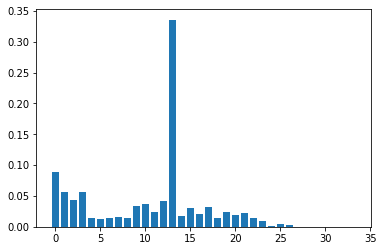

In [238]:
import matplotlib.pyplot as plt 
# logistic regression object 
lr = RandomForestClassifier(n_estimators=100) 
  
# train the model on train set 
lr.fit(X_train, y_train.values.ravel()) 
  
predictions = lr.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix)

 #get importance
importance = lr.feature_importances_
#summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
#plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [232]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.values.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

lr1 = RandomForestClassifier(n_estimators=100)  
lr1.fit(X_train_res, y_train_res.ravel()) 
predictions = lr1.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix)

# get importance
#importance = lr1.feature_importances_
# summarize feature importance
#for i,v in enumerate(importance):
    #print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
#pyplot.show()

Before OverSampling, counts of label '1': 225
Before OverSampling, counts of label '0': 11584 

After OverSampling, the shape of train_X: (23168, 41)
After OverSampling, the shape of train_y: (23168,) 

After OverSampling, counts of label '1': 11584
After OverSampling, counts of label '0': 11584
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      5912
         1.0       0.14      0.07      0.09       115

    accuracy                           0.97      6027
   macro avg       0.56      0.53      0.54      6027
weighted avg       0.97      0.97      0.97      6027

[[5863   49]
 [ 107    8]]


In [217]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# apply near miss 
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.values.ravel()) 
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

# train the model on train set 
lr2 = RandomForestClassifier(n_estimators=100) 
lr2.fit(X_train_miss, y_train_miss.ravel()) 
predictions = lr2.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix)

Before Undersampling, counts of label '1': 230
Before Undersampling, counts of label '0': 11579 

After Undersampling, the shape of train_X: (460, 41)
After Undersampling, the shape of train_y: (460,) 

After Undersampling, counts of label '1': 230
After Undersampling, counts of label '0': 230
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      5915
         1.0       0.31      1.00      0.47       112

    accuracy                           0.96      6027
   macro avg       0.65      0.98      0.72      6027
weighted avg       0.99      0.96      0.97      6027

[[5663  252]
 [   0  112]]


# Gradient Boosting Classifier

In [111]:
# logistic regression object 
lr = GradientBoostingClassifier() 
  
# train the model on train set 
lr.fit(X_train, y_train.values.ravel()) 
  
predictions = lr.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5915
         1.0       0.97      0.96      0.97       112

    accuracy                           1.00      6027
   macro avg       0.99      0.98      0.98      6027
weighted avg       1.00      1.00      1.00      6027

[[5912    3]
 [   4  108]]


In [112]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.values.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

lr1 =  GradientBoostingClassifier() 
lr1.fit(X_train_res, y_train_res.ravel()) 
predictions = lr1.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix)

Before OverSampling, counts of label '1': 231
Before OverSampling, counts of label '0': 11578 

After OverSampling, the shape of train_X: (23156, 39)
After OverSampling, the shape of train_y: (23156,) 

After OverSampling, counts of label '1': 11578
After OverSampling, counts of label '0': 11578
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5915
         1.0       0.95      1.00      0.97       112

    accuracy                           1.00      6027
   macro avg       0.97      1.00      0.99      6027
weighted avg       1.00      1.00      1.00      6027

[[5909    6]
 [   0  112]]


In [113]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# apply near miss 
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.values.ravel()) 
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

# train the model on train set 
lr2 =  GradientBoostingClassifier() 
lr2.fit(X_train_miss, y_train_miss.ravel()) 
predictions = lr2.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix)

Before Undersampling, counts of label '1': 231
Before Undersampling, counts of label '0': 11578 

After Undersampling, the shape of train_X: (462, 39)
After Undersampling, the shape of train_y: (462,) 

After Undersampling, counts of label '1': 231
After Undersampling, counts of label '0': 231
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98      5915
         1.0       0.29      1.00      0.45       112

    accuracy                           0.95      6027
   macro avg       0.64      0.98      0.71      6027
weighted avg       0.99      0.95      0.97      6027

[[5638  277]
 [   0  112]]


# GradientBoostingRegressor

In [138]:
from sklearn.ensemble import GradientBoostingRegressor
# logistic regression object 
lr = GradientBoostingRegressor() 
  
# train the model on train set 
lr.fit(X_train, y_train.values.ravel()) 
  
predictions = lr.predict(X_test) 
  
# print classification report 
#print(classification_report(y_test, predictions))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [139]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.values.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

lr1 =  GradientBoostingRegressor() 
lr1.fit(X_train_res, y_train_res.ravel()) 
predictions = lr1.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix)

Before OverSampling, counts of label '1': 231
Before OverSampling, counts of label '0': 11578 

After OverSampling, the shape of train_X: (23156, 39)
After OverSampling, the shape of train_y: (23156,) 

After OverSampling, counts of label '1': 11578
After OverSampling, counts of label '0': 11578


ValueError: Classification metrics can't handle a mix of binary and continuous targets